In [1]:
import json
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import gensim.models as models
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def preprocess(text:str, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if re.match(r'(\d.|\d)', lemma) is None:
                if lemma not in stop_words:
                    preprocessed_text.append(lemma)
    return preprocessed_text

def read_json(path: str):
    file = open(path)
    data = json.load(file)
    return pd.DataFrame(data)

def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(sim.size):
        if df['need_match'][i]:
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

def calc_accuracy(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
    return round(float((TP + TN) / (TP + TN + FP + FN)), 3)


punctuation_marks = ['!', ',', '(', ')', ';', ':', '-', '?', '.', '..', '...', "\"", "/", "\`\`", "»", "«" ]
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [128]:
class ModelResearcher:
    def __init__(self):
        self.model = None
    
    def preprocess_and_save(self, data_df: pd.DataFrame, path, text_field='text') -> pd.DataFrame:
        # for preprocessing dataset. Use it only in critical cases cause it's too slow on big datasets
        data_df['preprocessed_' + text_field] = data_df.apply(lambda row: preprocess(row[text_field], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def preprocess_and_save_pairs(self, data_df: pd.DataFrame, path, text_field_1, text_field_2) -> pd.DataFrame:
        data_df['preprocessed_' + text_field_1] = data_df.apply(lambda row: preprocess(row[text_field_1], punctuation_marks, stop_words, morph), axis=1)
        data_df['preprocessed_' + text_field_2] = data_df.apply(lambda row: preprocess(row[text_field_2], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field_1, text_field_2], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def train(self, data_df: pd.DataFrame, model="w2v"):            
        if model == "w2v":
            train_part = data_df['preprocessed_texts']
            self.model = gensim.models.Word2Vec(sentences=train_part, min_count=5, vector_size=50, epochs=5)
            self.model.save('w2v')
        elif model == "fast_text":
            train_part = data_df['preprocessed_texts'].tolist()
            self.model = gensim.models.FastText(vector_size=50, min_count=5)
            self.model.build_vocab(corpus_iterable=train_part)
            self.model.train(corpus_iterable=train_part, total_examples=len(train_part), epochs=5)
            self.model.save('fastText')
        return

                    
    
    def predict_sentences_similarity(self, sentences_1: pd.Series, sentences_2: pd.Series):
        if sentences_1.size != sentences_2.size:
            return None
        else:
            if self.model is not None:
                sentences_sim = np.zeros(sentences_1.size)
                sz = sentences_1.size
                for i in range(sz): 
                    sentences_1_words = [w for w in sentences_1[i] if w in self.model.wv.index_to_key]
                    sentences_2_words = [w for w in sentences_2[i] if w in self.model.wv.index_to_key]
                    sim = self.model.wv.n_similarity(sentences_1_words, sentences_2_words)
                    sentences_sim[i] = sim
                
                return sentences_sim
            else:
                return None
        
    def get_train_test_dfs_for_f1(self, df_match, df_unmatch): 
        df_match = shuffle(df_match)
        df_unmatch = shuffle(df_unmatch)
        
        df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
        df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
        return (df_train_f1, df_test_f1)
    
    
    def get_optimal_threshold(self, sentences_1: pd.Series, sentences_2: pd.Series, df, step=0.02):
        if sentences_1.size != sentences_2.size or self.model is None:
            return None
        else:
            threshold = 0
            thresholds = []
            max_ = 0
            h = step
            steps = np.linspace(0, 1, num=int(1/h))
            steps = np.round(steps, 2)
            h_max = 0
            sim =  self.predict_sentences_similarity( sentences_1, sentences_2)
            for i in steps:
                threshold = calc_f1_score(sim, df, h)
                print(h, threshold)
                thresholds.append(threshold)
                if threshold > max_:
                    max_ = threshold
                    h_max = h
                h += step
            plt.plot(steps, thresholds)
            plt.figure(figsize=(10,3))
            plt.show()
            
            return h_max

## Обучим word2vec

In [129]:
data_df = read_json('./preprocessed_documents.json')
modelResearcher_w2v = ModelResearcher()
modelResearcher_w2v.train(data_df, model="w2v")
# modelResearcher_w2v.model = models.ldamodel.LdaModel.load('./w2v')
modelResearcher_w2v.model

In [130]:
match_unmatch_df = read_json('./dataset.json')

In [131]:
# match_unmatch_df

In [132]:
df_match = match_unmatch_df[ match_unmatch_df['need_match'] == True][:-2]
df_unmatch = match_unmatch_df[match_unmatch_df['need_match'] == False]

df_train_f1, df_test_f1 = modelResearcher_w2v.get_train_test_dfs_for_f1(df_match, df_unmatch)

In [133]:
print('df_train: {} of {}'.format(df_train_f1['id_rp'].size, match_unmatch_df ['id_rp'].size))
print('df_test: {} of {}'.format(df_test_f1['id_rp'].size,match_unmatch_df['id_rp'].size))

df_train: 22 of 46
df_test: 22 of 46


In [134]:
df_train_f1 = modelResearcher_w2v.preprocess_and_save_pairs(df_train_f1, None, 'text_rp', 'text_proj')
df_test_f1 = modelResearcher_w2v.preprocess_and_save_pairs(df_test_f1, None, 'text_rp', 'text_proj')

In [135]:
result_w2v_train = modelResearcher_w2v.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
print(result_w2v_train)

[0.77876627 0.82473212 0.88759834 0.90513813 0.78248847 0.80279559
 0.62541145 0.7449289  0.73357129 0.85430914 0.86086893 0.40470386
 0.72429937 0.45979097 0.14298782 0.7447502  0.66249424 0.70209455
 0.38735184 0.71113294 0.55092555 0.76066607]


0.02 0.667
0.04 0.667
0.06 0.667
0.08 0.667
0.1 0.667
0.12000000000000001 0.667
0.14 0.667
0.16 0.688
0.18 0.688
0.19999999999999998 0.688
0.21999999999999997 0.688
0.23999999999999996 0.688
0.25999999999999995 0.688
0.27999999999999997 0.688
0.3 0.688
0.32 0.688
0.34 0.688
0.36000000000000004 0.688
0.38000000000000006 0.688
0.4000000000000001 0.71
0.4200000000000001 0.733
0.4400000000000001 0.733
0.46000000000000013 0.759
0.48000000000000015 0.759
0.5000000000000001 0.759
0.5200000000000001 0.759
0.5400000000000001 0.759
0.5600000000000002 0.786
0.5800000000000002 0.786
0.6000000000000002 0.786
0.6200000000000002 0.786
0.6400000000000002 0.741
0.6600000000000003 0.741
0.6800000000000003 0.769
0.7000000000000003 0.769
0.7200000000000003 0.833
0.7400000000000003 0.818
0.7600000000000003 0.8
0.7800000000000004 0.778
0.8000000000000004 0.706
0.8200000000000004 0.625
0.8400000000000004 0.533
0.8600000000000004 0.429
0.8800000000000004 0.308
0.9000000000000005 0.167
0.9200000000000005 0.0
0

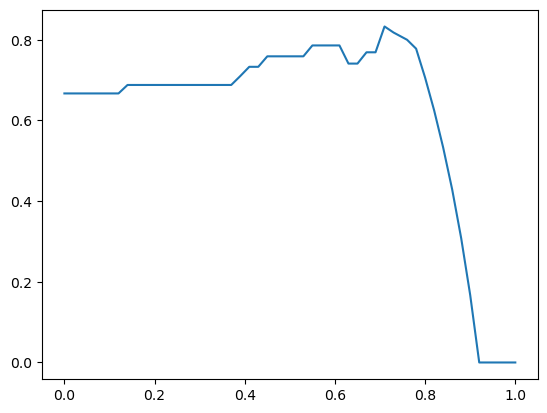

<Figure size 1000x300 with 0 Axes>

In [136]:
result_w2v_train_opt = modelResearcher_w2v.get_optimal_threshold(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'], df_train_f1, 0.02)

In [139]:
print(result_w2v_train_opt)

0.7200000000000003


In [140]:
f1_w2v_train = calc_f1_score(result_w2v_train, df_train_f1, result_w2v_train_opt)
acc_w2v_train = calc_accuracy(result_w2v_train, df_train_f1, result_w2v_train_opt)
print('F1-score train w2v: {}'.format(f1_w2v_train ))
print('accuracy train w2v: {}'.format(acc_w2v_train))
df_train_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_train_f1.insert(loc=4, column='score', value=result_w2v_train) 
# df_train_f1

F1-score train w2v: 0.833
accuracy train w2v: 0.818


In [141]:
result_w2v_test = modelResearcher_w2v.predict_sentences_similarity(df_test_f1['preprocessed_text_rp'], df_test_f1['preprocessed_text_proj'])
f1_w2v_test = calc_f1_score(result_w2v_test, df_test_f1, result_w2v_train_opt)
acc_w2v_test = calc_accuracy(result_w2v_test, df_test_f1, result_w2v_train_opt)
print('F1-score test w2v: {}'.format(f1_w2v_test))
print('accuracy test w2v: {}'.format(acc_w2v_test))

F1-score test w2v: 0.727
accuracy test w2v: 0.727


In [45]:
df_test_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_test_f1.insert(loc=4, column='score', value=result_w2v_test) 
df_test_f1[8:]

,id_rp,id_proj,name_rp,name_proj,score,need_match,preprocessed_text_rp,preprocessed_text_proj
8,1447,43,Моделирование нелинейных динамических систем,Нелинейная динамика и приложения теории хаоса,0.916085,True,"[дисциплина, направить, ознакомление, студент,...","[нелинейный, динамика, приложение, теория, хао..."
9,1011,14,Тестирование и сопровождение программного обес...,Тестирование и документирование стенда виртуал...,0.833684,True,"[цель, дисциплина, охватывать, ряд, направлени...","[тестирование, документирование, стенд, виртуа..."
10,1005,40,АНАЛИЗ ДАННЫХ В ИСКУССТВЕННОМ ИНТЕЛЛЕКТЕ,Роботизированная система машинного творчества ...,0.785757,True,"[освещать, курс, теоретический, прикладной, во...","[роботизированный, система, машинный, творчест..."
11,2649,16,Философия,Разработка системы вскрытия объектов на кадрах...,0.466503,False,"[философия, –, гуманитарный, дисциплина, изуча...","[разработка, система, вскрытие, объект, кадр, ..."
12,5105,11,Дискретная математика и теоретическая информатика,Анализ динамики COVID-19 в России,0.579052,False,"[раздел, современный, математика, иметь, прило...","[анализ, динамика, covid-19, россия, ·, web-пр..."
13,5663,47,Тестирование и сопровождение программного обес...,Анализ и обучение рекомендательных моделей для...,0.736066,False,"[цель, дисциплина, охватывать, ряд, направлени...","[анализ, обучение, рекомендательный, модель, ф..."
14,1557,30,Бережливые технологии в менеджменте качества,Разработка системы детектирования и идентифика...,0.741649,False,"[цель, освоение, дисциплина, бережливый, техно...","[разработка, система, детектирование, идентифи..."
15,683,38,Методы осуществления компьютерных атак и вирус...,Разработка системы звукоподводной связи на осн...,0.861592,False,"[дисциплина, обеспечивать, получение, знание, ...","[разработка, система, звукоподводный, связь, о..."
16,6093,56,Математический анализ,Практика в проектах по автономному транспорту ...,0.637199,False,"[математический, анализ, ключевой, раздел, выс...","[практика, проект, автономный, транспорт, ао, ..."
17,2646,44,Диэлектрические материалы и приборы,Разработка системы проверки доставки писем на ...,0.305069,False,"[рассматриваться, современный, представление, ...","[разработка, система, проверка, доставка, пись..."


## Leave One Out

In [197]:
def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)
    
def max_f1_score(sim, df):
    threshold = 0
    thresholds = []
    max_ = 0
    step_max_ = 0
    step = 0.02
    h = step
    steps = np.linspace(0, 1, num=int(1/h))
    steps = np.round(steps, 2)

    for i in steps:
        threshold = calc_f1_score(sim, df, h)
        thresholds.append(threshold)
        if threshold > max_:
            max_ = threshold
            step_max_ = h
        h += step
    
    return (steps, thresholds, max_, step_max_)

In [163]:
# df_train_f1

In [198]:
N = len(df_train_f1)


sim = modelResearcher_w2v.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
sim = list(sim)
predictions = []
for i in range(N):
    current_df = df_train_f1.drop(i).reset_index().drop(labels='index', axis=1)
    current_sim = sim[:i] + sim[i+1:]
    steps, thresholds, max_, cutoff = max_f1_score(current_sim, current_df)
    print(max_, cutoff)
    if sim[i] >= cutoff:
      predictions.append(True)
    else:
      predictions.append(False)

0.824 0.7800000000000004
0.818 0.7200000000000003
0.818 0.7200000000000003
0.818 0.7200000000000003
0.818 0.7200000000000003
0.818 0.7200000000000003
0.87 0.7200000000000003
0.842 0.7600000000000003
0.857 0.7400000000000003
0.818 0.7200000000000003
0.818 0.7200000000000003
0.833 0.7200000000000003
0.87 0.7200000000000003
0.833 0.7200000000000003
0.833 0.7200000000000003
0.87 0.7200000000000003
0.833 0.7200000000000003
0.833 0.7200000000000003
0.833 0.7200000000000003
0.833 0.7200000000000003
0.833 0.7200000000000003
0.87 0.7200000000000003


In [199]:
def get_states_leave_one_out(predictions, df):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if predictions[i]: 
                TP += 1
            else:
                FN += 1
        else:
            if predictions[i]: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score_loo(calc_states):
    (TP, FP, FN, TN) = calc_states()
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

In [200]:
calc_f1_score_loo(lambda: get_states_leave_one_out(predictions, df_train_f1))

0.667

## FastText

In [184]:
modelResearcher_ft = ModelResearcher()
data_df = read_json('./preprocessed_documents.json')
modelResearcher_ft.train(data_df, model="fast_text")


In [177]:
# modelResearcher_ft = ModelResearcher()
# modelResearcher_ft.model = models.ldamodel.LdaModel.load('ft')

0.02 0.667
0.04 0.667
0.06 0.667
0.08 0.667
0.1 0.667
0.12000000000000001 0.667
0.14 0.667
0.16 0.667
0.18 0.667
0.19999999999999998 0.667
0.21999999999999997 0.667
0.23999999999999996 0.667
0.25999999999999995 0.667
0.27999999999999997 0.667
0.3 0.667
0.32 0.667
0.34 0.667
0.36000000000000004 0.667
0.38000000000000006 0.667
0.4000000000000001 0.667
0.4200000000000001 0.667
0.4400000000000001 0.667
0.46000000000000013 0.667
0.48000000000000015 0.688
0.5000000000000001 0.688
0.5200000000000001 0.688
0.5400000000000001 0.688
0.5600000000000002 0.688
0.5800000000000002 0.688
0.6000000000000002 0.688
0.6200000000000002 0.688
0.6400000000000002 0.688
0.6600000000000003 0.733
0.6800000000000003 0.733
0.7000000000000003 0.733
0.7200000000000003 0.786
0.7400000000000003 0.815
0.7600000000000003 0.815
0.7800000000000004 0.8
0.8000000000000004 0.783
0.8200000000000004 0.857
0.8400000000000004 0.737
0.8600000000000004 0.706
0.8800000000000004 0.533
0.9000000000000005 0.429
0.9200000000000005 0.16

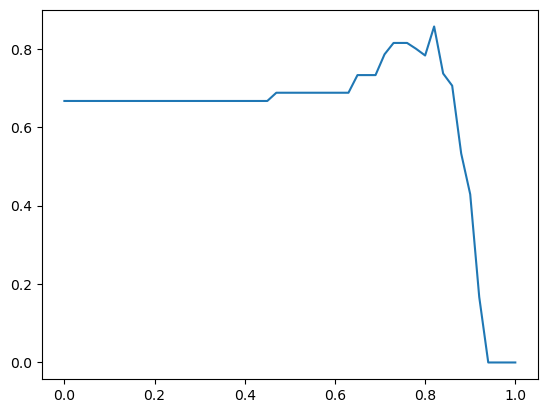

<Figure size 1000x300 with 0 Axes>

In [191]:
result_ft_train_opt = modelResearcher_ft.get_optimal_threshold(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'], df_train_f1, 0.02)

In [192]:
print(result_ft_train_opt)

0.8200000000000004


In [193]:
result_ft_train = modelResearcher_ft.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
f1_ft_train = calc_f1_score(result_ft_train, df_train_f1, result_ft_train_opt)
acc_ft_train = calc_accuracy(result_ft_train, df_train_f1, result_ft_train_opt)
print('F1-score train ft: {}'.format(f1_ft_train ))
print('accuracy train ft: {}'.format(acc_ft_train ))
df_train_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_train_f1.insert(loc=4, column='score', value=result_ft_train) 

F1-score train ft: 0.857
accuracy train ft: 0.864


In [194]:
result_ft_test = modelResearcher_ft.predict_sentences_similarity(df_test_f1['preprocessed_text_rp'], df_test_f1['preprocessed_text_proj'])
f1_ft_test = calc_f1_score(result_ft_test, df_test_f1, result_ft_train_opt)
acc_ft_test = calc_accuracy(result_ft_test, df_test_f1, result_ft_train_opt)
print('F1-score test ft: {}'.format(f1_ft_test))
print('accuracy test ft: {}'.format(acc_ft_test ))
df_test_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_test_f1.insert(loc=4, column='score', value=result_ft_test) 

F1-score test ft: 0.762
accuracy test ft: 0.773


In [195]:
N = len(df_train_f1)

sim = modelResearcher_ft.predict_sentences_similarity(df_train_f1['preprocessed_text_rp'], df_train_f1['preprocessed_text_proj'])
sim = list(sim)
predictions = []
for i in range(N):
    current_df = df_train_f1.drop(i).reset_index().drop(labels='index', axis=1)
    current_sim = sim[:i] + sim[i+1:]
    steps, thresholds, max_, cutoff = max_f1_score(current_sim, current_df)
    print(max_, cutoff)
    if sim[i] >= cutoff:
      predictions.append(True)
    else:
      predictions.append(False)

print(predictions)

0.9 0.8200000000000004
0.842 0.8200000000000004
0.842 0.8200000000000004
0.842 0.8200000000000004
0.842 0.8200000000000004
0.842 0.8200000000000004
0.842 0.8200000000000004
0.842 0.8200000000000004
0.9 0.8200000000000004
0.842 0.8200000000000004
0.842 0.8200000000000004
0.857 0.8200000000000004
0.9 0.8200000000000004
0.857 0.8200000000000004
0.857 0.8200000000000004
0.857 0.8200000000000004
0.857 0.8200000000000004
0.857 0.8200000000000004
0.857 0.8200000000000004
0.857 0.8200000000000004
0.857 0.8200000000000004
0.857 0.8200000000000004
[False, True, True, True, True, True, True, True, False, True, True, False, True, False, False, False, False, False, False, False, False, False]


In [196]:
calc_f1_score_loo(lambda: get_states_leave_one_out(predictions, df_train_f1))

0.857